# The capstone project (Seattle collisions data)

In [1]:
import numpy as np
import pandas as pd
pd.set_option('display.float_format', lambda x: '{:.3f}'.format(x)) #Limiting floats output to 3 decimal points
from matplotlib import pyplot as plt
%matplotlib inline
import seaborn as sns

In [2]:
print("Hello Capstone Project Course!")

Hello Capstone Project Course!


In [3]:
#https://data-seattlecitygis.opendata.arcgis.com/datasets/5b5c745e0f1f48e7a53acec63a0022ab_0
dfOriginal = pd.read_csv('Data-Collisions.csv')

C:\Users\carniato\AppData\Roaming\Python\Python37\site-packages\IPython\core\interactiveshell.py:3049: DtypeWarning: Columns (33) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


# Create train and test sets

Use startified samples, to get the same distributions of targets in the two sets

In [4]:
df=dfOriginal.copy()
y = df['SEVERITYCODE']
X = df.drop(['SEVERITYCODE'], axis=1)
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42,stratify =y)

train = pd.concat([X_train, y_train],axis=1)
test = pd.concat([X_test, y_test],axis=1)

# Define common functions

In [5]:
def compute_details(df): 
    obs = df.shape[0]
    types = df.dtypes
    counts = df.apply(lambda x: x.count())
    uniques = df.apply(lambda x: [x.unique()])
    nulls = df.apply(lambda x: x.isnull().sum())
    distincts = df.apply(lambda x: x.unique().shape[0])
    missing_ration = (df.isnull().sum()/ obs) * 100
    
    cols = ['types', 'counts', 'distincts', 'nulls', 'missing ration']
    details = pd.concat([types, counts, distincts, nulls, missing_ration], axis = 1)
    details.columns = cols
    
    return details

def get_indexses(df,col_missing_data,missingValue):
    if not missingValue :
        # nan
        indexses = df[col_missing_data].isnull()
    else:
        # comparables
        indexses = df[col_missing_data]==missingValue
        
    return indexses

def input_missing_values(df, col_missing_data, col_ref, missingValue = None):
    #group by nan or missing value
    invalid_idxs = get_indexses(df, col_missing_data, missingValue)
    df_notval = df[invalid_idxs]
    df_notval = df_notval.groupby(col_ref).sum()  
    #print(df_notval[col_ref])
    #the valid entries
    df_val = df[~invalid_idxs]
    
    #now check the values of the reference column
    for r in df_notval.index.values:
        if isinstance(r, str) or isinstance(r, np.int64) :
            #a string (e.g. a location)
            df_loc = df_val[df_val[col_ref]==r]
        elif len(r)==2:
            #two doubles
            df_loc = df_val[(df_val[col_ref[0]]==r[0]) & (df_val[col_ref[1]]==r[1])]
        
        if len(df_loc) > 0:
            val = df_loc[col_missing_data].iloc[0]
            if isinstance(r, str) or isinstance(r, np.int64) :
                #substitute with the first valid value
                df.loc[(df[col_ref]==r) & invalid_idxs,col_missing_data]=val
            elif len(r) ==2:
                df.loc[(df[col_ref[0]]==r[0]) &(df[col_ref[1]]==r[1]) & invalid_idxs, col_missing_data] = val
        
    return df     

from scipy import stats
from statsmodels.stats import weightstats as stests
def bar_chart(datafr, feature):
    # z-test
    grp1 = datafr[datafr['SEVERITYCODE']==1][feature]
    grp2 =datafr[datafr['SEVERITYCODE']==2][feature]        
    #bar chart
    severityOne = grp1.value_counts()
    #print(severityOne[0]/(severityOne[0] + severityOne[1]))
    severityTwo = grp2.value_counts()
    #print(severityTwo[0]/(severityTwo[0] + severityTwo[1]))
    df = pd.DataFrame([severityOne,severityTwo])
    df.index = ['SEVERITYCODE 1','SEVERITYCODE 2']
    df.plot(kind='bar',stacked=True, figsize=(10,5))
    
from sklearn.preprocessing import LabelEncoder
def prepare_categorical(train_label, test_label):
    le = LabelEncoder()
    le.fit(train_label)
    train_label_enc = le.transform(train_label)
    test_label_enc = le.transform(test_label)
    return train_label_enc, test_label_enc


def CalculateZTest(datafr, feature):
    grp1 = datafr[datafr['SEVERITYCODE']==1][feature]
    grp2 =datafr[datafr['SEVERITYCODE']==2][feature]
    ztest ,pval = stests.ztest(grp1, x2=grp2, value=0,alternative='two-sided')
    if pval<0.05:
        print("reject null hypothesis, groups are different, pval ", float(pval))
    else:
        print("accept null hypothesis, groups are not different, pval", float(pval))

In [6]:
details = compute_details(train)
print(details)

                  types  counts  distincts   nulls  missing ration
X               float64  126901      20954    3529           2.706
Y               float64  126901      21200    3529           2.706
OBJECTID          int64  130430     130430       0           0.000
INCKEY            int64  130430     130430       0           0.000
COLDETKEY         int64  130430     130430       0           0.000
REPORTNO         object  130430     130428       0           0.000
STATUS           object  130430          2       0           0.000
ADDRTYPE         object  129162          4    1268           0.972
INTKEY          float64   43707       6732   86723          66.490
LOCATION         object  128674      21416    1756           1.346
EXCEPTRSNCODE    object   56823          3   73607          56.434
EXCEPTRSNDESC    object    3792          2  126638          97.093
SEVERITYCODE.1    int64  130430          2       0           0.000
SEVERITYDESC     object  130430          2       0           0

# Drop features containing administrative information or post-collision features

In [7]:
admin_columns = ['REPORTNO', 'COLLISIONTYPE','ST_COLCODE','ST_COLDESC','SDOT_COLCODE','SDOTCOLNUM','SDOT_COLDESC',
              'OBJECTID','INCKEY','COLDETKEY','STATUS','COLLISIONTYPE','INTKEY','LOCATION','INATTENTIONIND','UNDERINFL',
                'PEDROWNOTGRNT']

train = train.drop(admin_columns,axis=1)
test = test.drop(admin_columns,axis=1)

# Use X,Y for filling missing values in JUNCTIONTYPE column

In [8]:
train = input_missing_values(train, 'JUNCTIONTYPE', ['X','Y'])
test = input_missing_values(test, 'JUNCTIONTYPE', ['X','Y'])

# Save dataframe

In [9]:
train.to_csv('Data-Collisions-raw-train.csv')
test.to_csv('Data-Collisions-raw-test.csv')

# Load dataframe

In [10]:
import numpy as np
import pandas as pd
pd.set_option('display.float_format', lambda x: '{:.3f}'.format(x)) #Limiting floats output to 3 decimal points
from matplotlib import pyplot as plt
%matplotlib inline
import seaborn as sns

In [11]:
train = pd.read_csv('Data-Collisions-raw-train.csv')
train = train.drop(['Unnamed: 0'], axis=1)

In [12]:
test = pd.read_csv('Data-Collisions-raw-test.csv')
test = test.drop(['Unnamed: 0'], axis=1)

# Drop selected features

Eliminate features identical to the target or containing the same type of information

In [13]:
train = train.drop(['SEVERITYCODE.1'], axis=1)
test = test.drop(['SEVERITYCODE.1'], axis=1)

train = train.drop(['SEVERITYDESC'], axis=1)
test = test.drop(['SEVERITYDESC'], axis=1)

Eliminate EXCEPTRSNDESC, not clear from the description what it is about

In [14]:
train['EXCEPTRSNDESC'].value_counts()

Not Enough Information, or Insufficient Location Information    3792
Name: EXCEPTRSNDESC, dtype: int64

In [15]:
train = train.drop(['EXCEPTRSNDESC'], axis=1)
test = test.drop(['EXCEPTRSNDESC'], axis=1)

Eliminate EXCEPTRSNCODE, not clear from the description what it is about

In [16]:
train['EXCEPTRSNCODE'].value_counts()

       53031
NEI     3792
Name: EXCEPTRSNCODE, dtype: int64

In [17]:
train = train.drop(['EXCEPTRSNCODE'], axis=1)
test = test.drop(['EXCEPTRSNCODE'], axis=1)

# Replace missing values

In [18]:
details = compute_details(train)
print(details)

details = compute_details(test)
print(details)

                types  counts  distincts   nulls  missing ration
X             float64  126901      20954    3529           2.706
Y             float64  126901      21200    3529           2.706
ADDRTYPE       object  129162          4    1268           0.972
PERSONCOUNT     int64  130430         44       0           0.000
PEDCOUNT        int64  130430          6       0           0.000
PEDCYLCOUNT     int64  130430          3       0           0.000
VEHCOUNT        int64  130430         12       0           0.000
INCDATE        object  130430       5983       0           0.000
INCDTTM        object  130430     109974       0           0.000
JUNCTIONTYPE   object  128733          8    1697           1.301
WEATHER        object  126977         12    3453           2.647
ROADCOND       object  127022         10    3408           2.613
LIGHTCOND      object  126926         10    3504           2.686
SPEEDING       object    6271          2  124159          95.192
SEGLANEKEY      int64  13

In [19]:
train['SPEEDING'].value_counts()

Y    6271
Name: SPEEDING, dtype: int64

In [20]:
train['SPEEDING'] = train['SPEEDING'].replace(np.nan,0)
test['SPEEDING'] = test['SPEEDING'].replace(np.nan,0)

train['SPEEDING'] = train['SPEEDING'].replace('Y',1)
test['SPEEDING'] = test['SPEEDING'].replace('Y',1)

In [21]:
train['LIGHTCOND'].value_counts()

Daylight                    77783
Dark - Street Lights On     32401
Unknown                      9092
Dusk                         3994
Dawn                         1669
Dark - No Street Lights      1015
Dark - Street Lights Off      809
Other                         155
Dark - Unknown Lighting         8
Name: LIGHTCOND, dtype: int64

In [22]:
train['LIGHTCOND'] = train['LIGHTCOND'].replace(np.nan,'Unknown')
test['LIGHTCOND'] = test['LIGHTCOND'].replace(np.nan,'Unknown')

In [23]:
train['ROADCOND'].value_counts()

Dry               83405
Wet               31687
Unknown           10173
Ice                 812
Snow/Slush          691
Other                84
Standing Water       79
Sand/Mud/Dirt        51
Oil                  40
Name: ROADCOND, dtype: int64

In [24]:
train['ROADCOND'] = train['ROADCOND'].replace(np.nan,'Unknown')
test['ROADCOND'] = test['ROADCOND'].replace(np.nan,'Unknown')

In [25]:
train['WEATHER'].value_counts()

Clear                       74348
Raining                     22215
Overcast                    18541
Unknown                     10177
Snowing                       619
Other                         557
Fog/Smog/Smoke                387
Sleet/Hail/Freezing Rain       75
Blowing Sand/Dirt              36
Severe Crosswind               17
Partly Cloudy                   5
Name: WEATHER, dtype: int64

In [26]:
train['WEATHER'] = train['WEATHER'].replace(np.nan,'Unknown')
test['WEATHER'] = test['WEATHER'].replace(np.nan,'Unknown')

# Treat dates

INCDTTM can be dropped, the date already containedin INCDTTM

In [27]:
train['INCDTTM'] = pd.to_datetime(train['INCDTTM'])
test['INCDTTM'] = pd.to_datetime(test['INCDTTM'])

In [28]:
train = train.drop(['INCDATE'], axis=1)
test = test.drop(['INCDATE'], axis=1)

Create hour feature

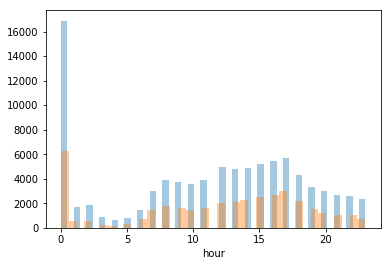

In [29]:
train['hour'] = train['INCDTTM'].dt.hour
test['hour'] = test['INCDTTM'].dt.hour

df_selected = train[train['SEVERITYCODE']==1]
sns.distplot(df_selected['hour'],kde = False)

df_selected = train[train['SEVERITYCODE']==2]
sns.distplot(df_selected['hour'],kde = False)

Create day of the week feature

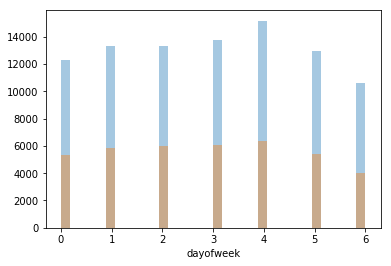

In [30]:
train['dayofweek'] = train['INCDTTM'].dt.dayofweek
test['dayofweek'] = test['INCDTTM'].dt.dayofweek

df_selected = train[train['SEVERITYCODE']==1]
sns.distplot(df_selected['dayofweek'],kde = False)
df_selected = train[train['SEVERITYCODE']==2]
sns.distplot(df_selected['dayofweek'],kde = False)

Create month feature 

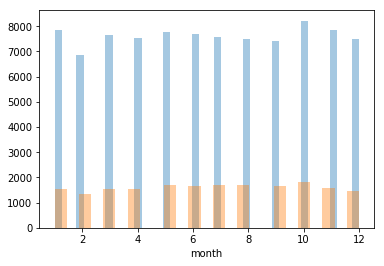

In [31]:
train['month'] = train['INCDTTM'].dt.month
test['month'] = test['INCDTTM'].dt.month

df_selected = train[train['SEVERITYCODE']==1]
sns.distplot(df_selected['month'],kde = False)
df_selected = test[test['SEVERITYCODE']==2]
sns.distplot(df_selected['month'],kde = False)

Create year feature  

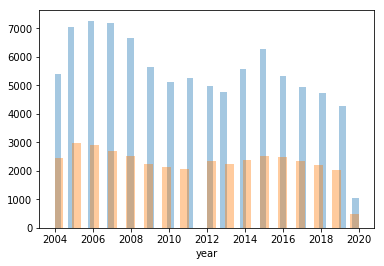

In [32]:
train['year'] = train['INCDTTM'].dt.year
test['year'] = test['INCDTTM'].dt.year

df_selected = train[train['SEVERITYCODE']==1]
sns.distplot(df_selected['year'],kde = False)
df_selected = train[train['SEVERITYCODE']==2]
sns.distplot(df_selected['year'],kde = False)

Remove INCDTTM after creating year, month, dayofweek, and hours features

In [33]:
train = train.drop(['INCDTTM'], axis=1)
test = test.drop(['INCDTTM'], axis=1)

# Drop extreme outliers

In [34]:
details = compute_details(train)
print(details)

                types  counts  distincts  nulls  missing ration
X             float64  126901      20954   3529           2.706
Y             float64  126901      21200   3529           2.706
ADDRTYPE       object  129162          4   1268           0.972
PERSONCOUNT     int64  130430         44      0           0.000
PEDCOUNT        int64  130430          6      0           0.000
PEDCYLCOUNT     int64  130430          3      0           0.000
VEHCOUNT        int64  130430         12      0           0.000
JUNCTIONTYPE   object  128733          8   1697           1.301
WEATHER        object  130430         11      0           0.000
ROADCOND       object  130430          9      0           0.000
LIGHTCOND      object  130430          9      0           0.000
SPEEDING        int64  130430          2      0           0.000
SEGLANEKEY      int64  130430       1432      0           0.000
CROSSWALKKEY    int64  130430       1704      0           0.000
HITPARKEDCAR   object  130430          2

PERSONCOUNT   0   81
2     76565
3     23735
4      9859
1      8768
5      4453
0      3732
6      1828
7       759
8       345
9       150
10       86
11       34
12       17
13       15
14       10
15        9
17        7
16        6
44        5
19        4
26        4
18        3
20        3
47        3
34        3
22        2
23        2
24        2
25        2
29        2
21        2
32        2
36        2
54        1
37        1
43        1
41        1
39        1
30        1
31        1
28        1
27        1
81        1
57        1
Name: PERSONCOUNT, dtype: int64
PEDCOUNT   0   6
0    125818
1      4442
2       150
3        15
4         4
6         1
Name: PEDCOUNT, dtype: int64
PEDCYLCOUNT   0   2
0    126705
1      3700
2        25
Name: PEDCYLCOUNT, dtype: int64
VEHCOUNT   0   11
2     98861
1     17238
3      8721
0      3455
4      1666
5       342
6        96
7        30
8        10
9         7
11        3
10        1
Name: VEHCOUNT, dtype: int64
SEGLANEKEY   0   52524

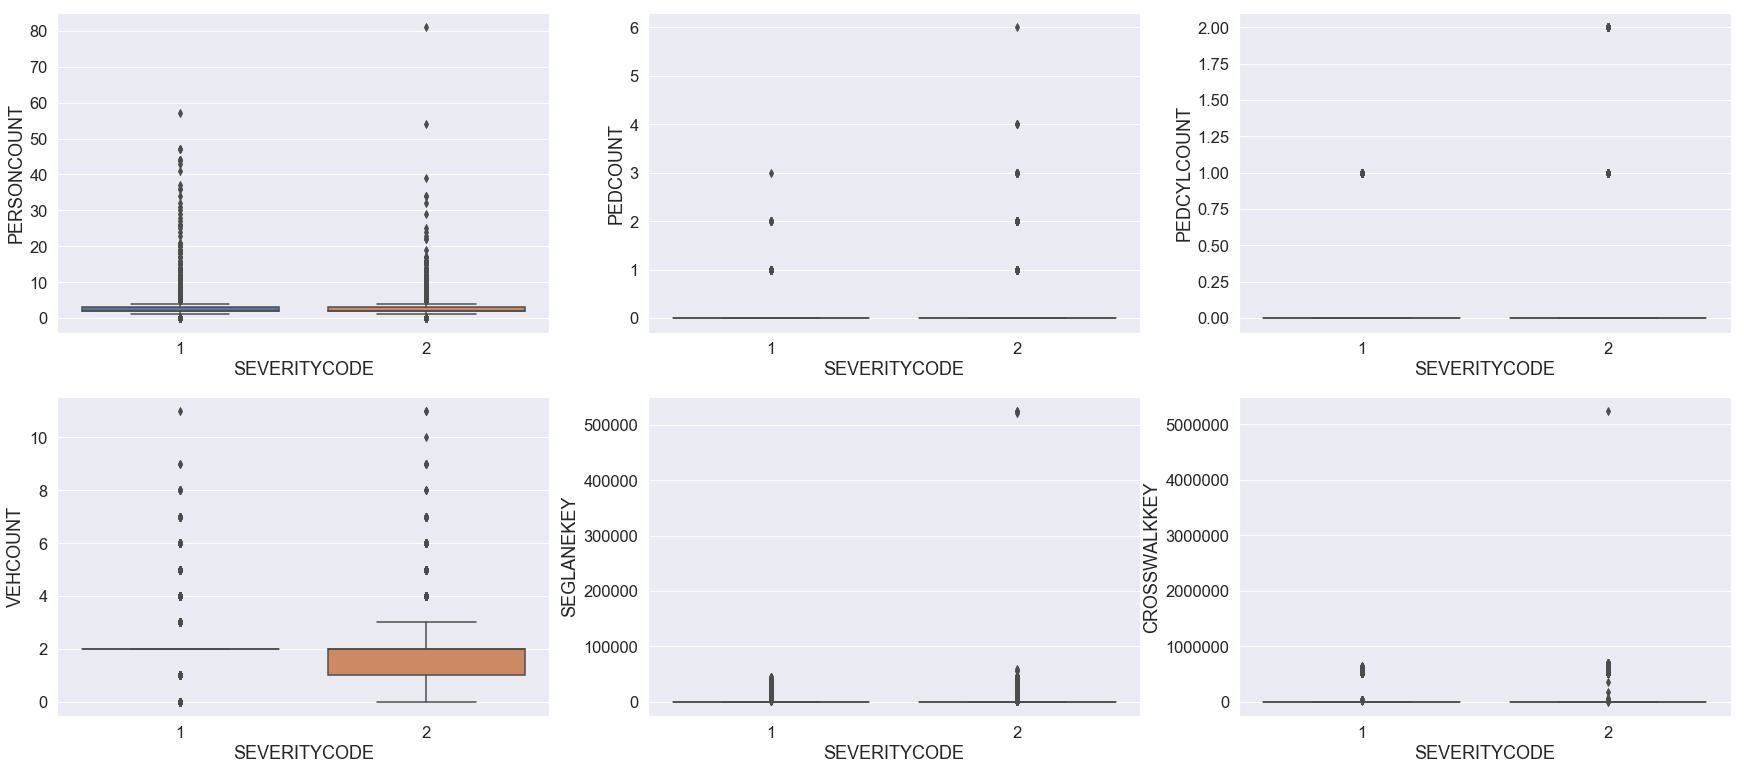

In [35]:
fig = plt.figure(figsize=(30, 20))
sns.set(font_scale=1.5)
key='PERSONCOUNT'
fig1 = fig.add_subplot(331); sns.boxplot(x='SEVERITYCODE', y=key, data=train[['SEVERITYCODE', key]])
print(key,' ', train[key].min(),' ',train[key].max())
print(train[key].value_counts())

key='PEDCOUNT'
fig1 = fig.add_subplot(332); sns.boxplot(x='SEVERITYCODE', y=key, data=train[['SEVERITYCODE', key]])
print(key,' ', train[key].min(),' ',train[key].max())
print(train[key].value_counts())


key='PEDCYLCOUNT'
fig1 = fig.add_subplot(333); sns.boxplot(x='SEVERITYCODE', y=key, data=train[['SEVERITYCODE', key]])
print(key,' ', train[key].min(),' ',train[key].max())
print(train[key].value_counts())

key='VEHCOUNT'
fig1 = fig.add_subplot(334); sns.boxplot(x='SEVERITYCODE', y=key, data=train[['SEVERITYCODE', key]])
print(key,' ', train[key].min(),' ',train[key].max())
print(train[key].value_counts())

key='SEGLANEKEY'
fig1 = fig.add_subplot(335); sns.boxplot(x='SEVERITYCODE', y=key, data=train[['SEVERITYCODE', key]])
print(key,' ', train[key].min(),' ',train[key].max())
print(train[key].value_counts())

key='CROSSWALKKEY'
fig1 = fig.add_subplot(336); sns.boxplot(x='SEVERITYCODE', y=key, data=train[['SEVERITYCODE', key]])
print(key,' ', train[key].min(),' ',train[key].max())
print(train[key].value_counts())

plt.savefig('BoxPlots.jpg', dpi=300, bbox_inches='tight')

Remove outliers

In [36]:
len_before = len(train)
train = train[train['PERSONCOUNT']<81]
train = train[train['SEGLANEKEY']<525241]
train = train[train['CROSSWALKKEY']<5239700]
len_after = len(train)
print("Num outliers removed in train set ",len_before-len_after)

len_before = len(test)
test = test[test['PERSONCOUNT']<81]
test = test[test['SEGLANEKEY']<525241]
test = test[test['CROSSWALKKEY']<5239700]
len_after = len(test)
print("Num outliers removed in test set ",len_before-len_after)

Num outliers removed in train set  3
Num outliers removed in test set  0


# Drop all remaining missing values

In [37]:
len_before = len(train)
train.dropna(inplace=True)
len_after = len(train)
print('percentage dropped  in train set ',(len_before - len_after)/len_before * 100.0)

len_before = len(test)
test.dropna(inplace=True)
len_after = len(test)
print('percentage dropped  in test set ',(len_before - len_after)/len_before * 100.0)

percentage dropped  in train set  2.9257745712160825
percentage dropped  in test set  3.2812913469171736


# Convert categorical to numerical (using only labels in the train set)

In [38]:
train['ADDRTYPE'], test['ADDRTYPE'] = prepare_categorical(train['ADDRTYPE'], test['ADDRTYPE'])
train['JUNCTIONTYPE'], test['JUNCTIONTYPE'] = prepare_categorical(train['JUNCTIONTYPE'], test['JUNCTIONTYPE'])
train['WEATHER'], test['WEATHER'] = prepare_categorical(train['WEATHER'], test['WEATHER'])
train['ROADCOND'], test['ROADCOND'] = prepare_categorical(train['ROADCOND'], test['ROADCOND'])
train['LIGHTCOND'], test['LIGHTCOND'] = prepare_categorical(train['LIGHTCOND'], test['LIGHTCOND'])
train['HITPARKEDCAR'], test['HITPARKEDCAR'] = prepare_categorical(train['HITPARKEDCAR'], test['HITPARKEDCAR'])

# Explore data and verify if grouping by severity code produces significantly different groups

reject null hypothesis, groups are different, pval  0.0


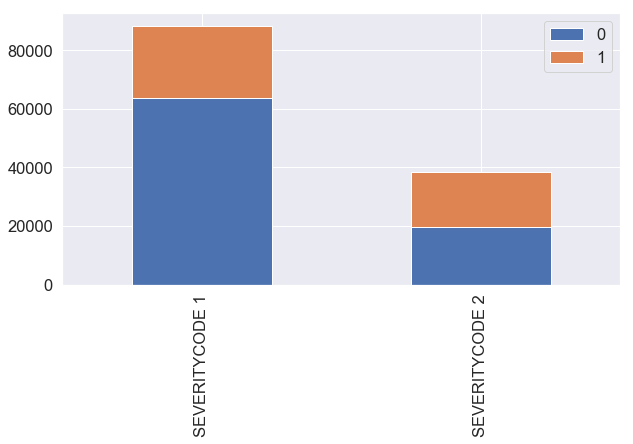

In [39]:
key = 'ADDRTYPE'
bar_chart(train, key)
CalculateZTest(train, key)

In [40]:
key = 'PERSONCOUNT'
CalculateZTest(train, key)

reject null hypothesis, groups are different, pval  0.0


reject null hypothesis, groups are different, pval  0.0


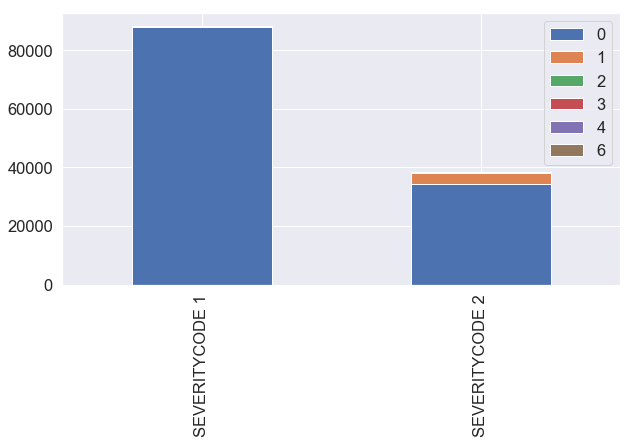

In [41]:
key = 'PEDCOUNT'
bar_chart(train, key)
CalculateZTest(train, key)
plt.savefig('PEDCOUNT.jpg', dpi=300, bbox_inches='tight')

reject null hypothesis, groups are different, pval  0.0


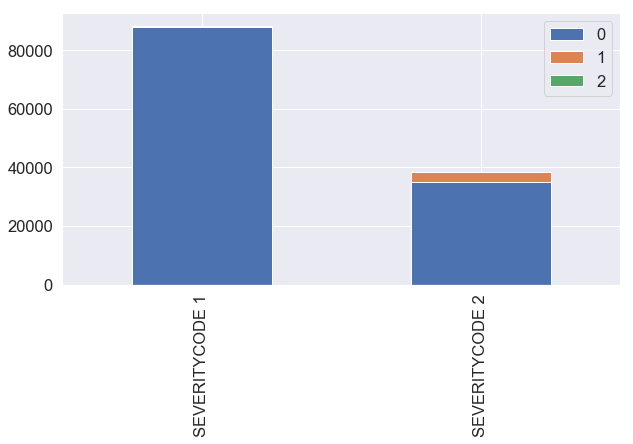

In [42]:
key = 'PEDCYLCOUNT'
bar_chart(train, key)
CalculateZTest(train, key)
plt.savefig('PEDCYLCOUNT.jpg', dpi=300, bbox_inches='tight')

reject null hypothesis, groups are different, pval  1.226117406830584e-97


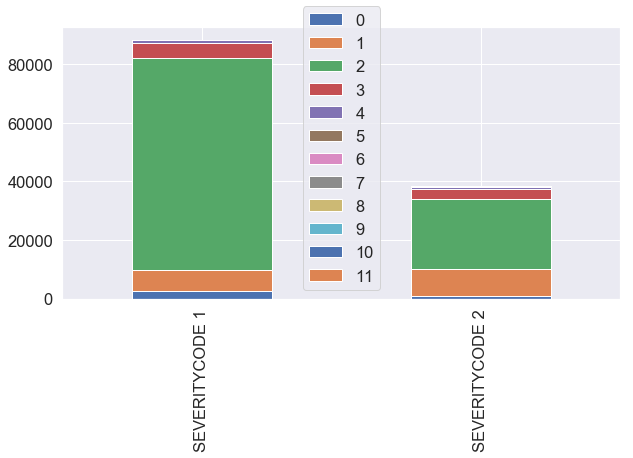

In [43]:
key = 'VEHCOUNT'
bar_chart(train, key)
CalculateZTest(train, key)

reject null hypothesis, groups are different, pval  0.0


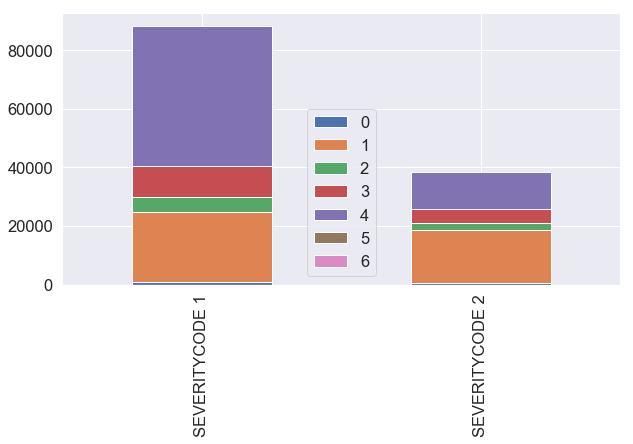

In [44]:
key = 'JUNCTIONTYPE'
bar_chart(train, key)
CalculateZTest(train, key)

reject null hypothesis, groups are different, pval  0.0


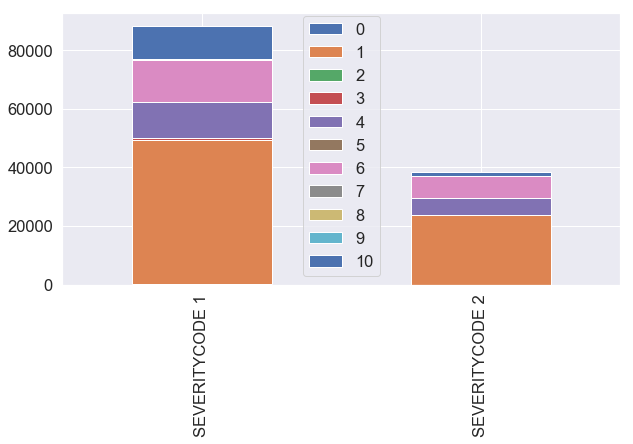

In [45]:
key = 'WEATHER'
bar_chart(train, key)
CalculateZTest(train, key)

reject null hypothesis, groups are different, pval  6.458500390186737e-71


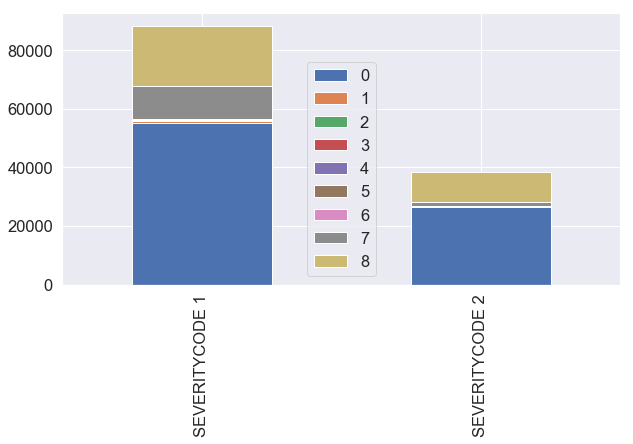

In [46]:
key = 'ROADCOND'
bar_chart(train, key)
CalculateZTest(train, key)

reject null hypothesis, groups are different, pval  3.7463622853906684e-112


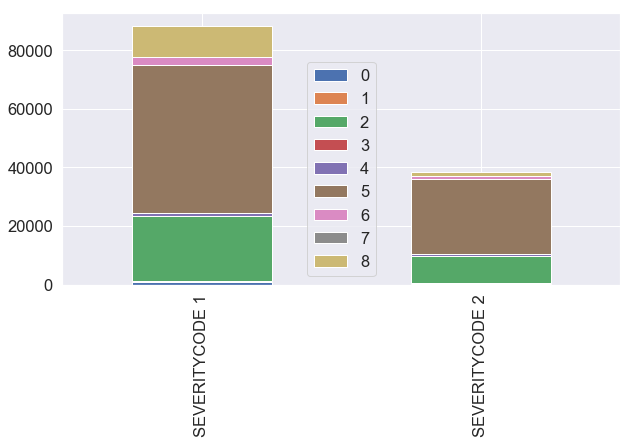

In [47]:
key = 'LIGHTCOND'
bar_chart(train, key)
CalculateZTest(train, key)

reject null hypothesis, groups are different, pval  2.0379919224168573e-38


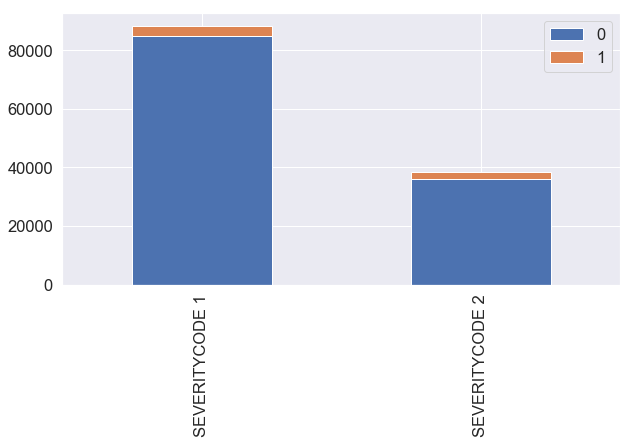

In [48]:
key = 'SPEEDING'
bar_chart(train, key)
CalculateZTest(train, key)

In [49]:
key = 'SEGLANEKEY'
CalculateZTest(train, key)

reject null hypothesis, groups are different, pval  0.0


In [50]:
key = 'CROSSWALKKEY'
CalculateZTest(train, key)

reject null hypothesis, groups are different, pval  0.0


reject null hypothesis, groups are different, pval  3.1017860335213858e-30


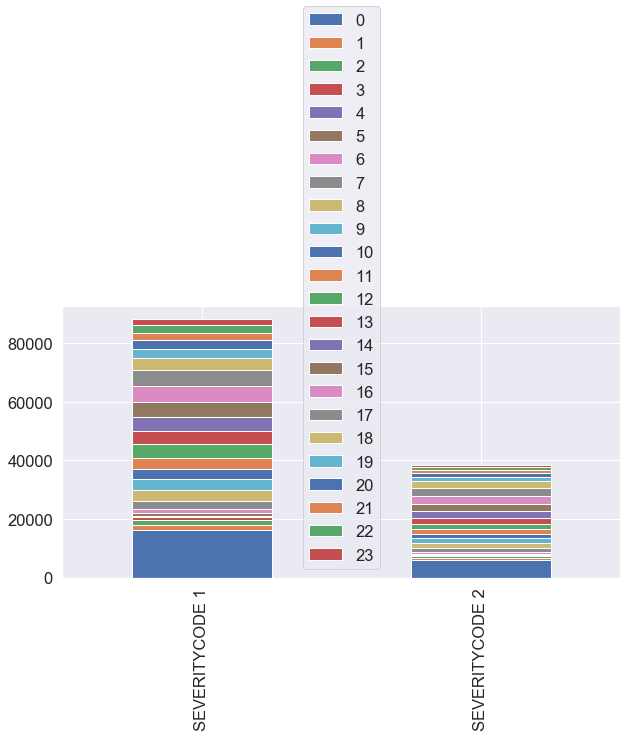

In [51]:
key = 'hour'
bar_chart(train, key)
CalculateZTest(train, key)

reject null hypothesis, groups are different, pval  2.033998104370034e-09


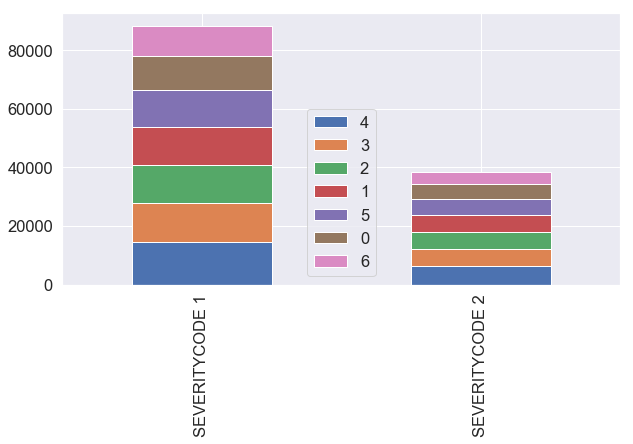

In [52]:
key = 'dayofweek'
bar_chart(train, key)
CalculateZTest(train, key)

accept null hypothesis, groups are not different, pval 0.46584493738477384


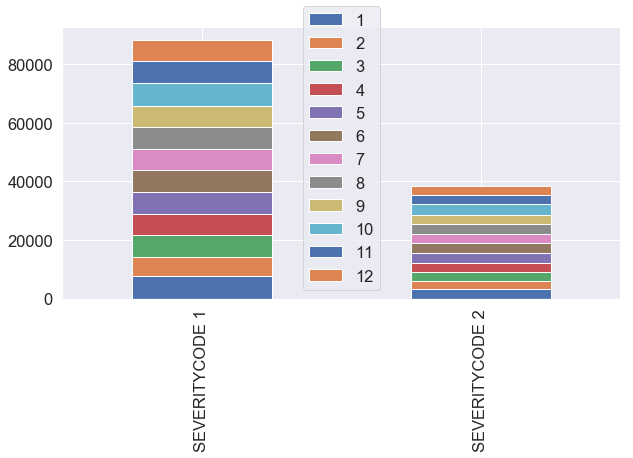

In [53]:
key = 'month'
bar_chart(train, key)
CalculateZTest(train, key)
plt.savefig('month.jpg', dpi=300, bbox_inches='tight')

reject null hypothesis, groups are different, pval  5.186112722854506e-16


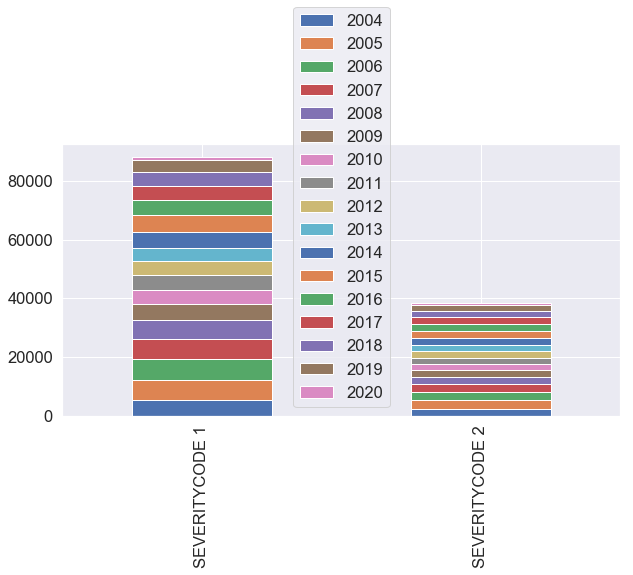

In [54]:
key = 'year'
bar_chart(train, key)
CalculateZTest(train, key)

Only the feature month is not substantially different between the two groups, drop it

In [55]:
train = train.drop(['month'], axis=1)
test = test.drop(['month'], axis=1)

# Find highly correleted features

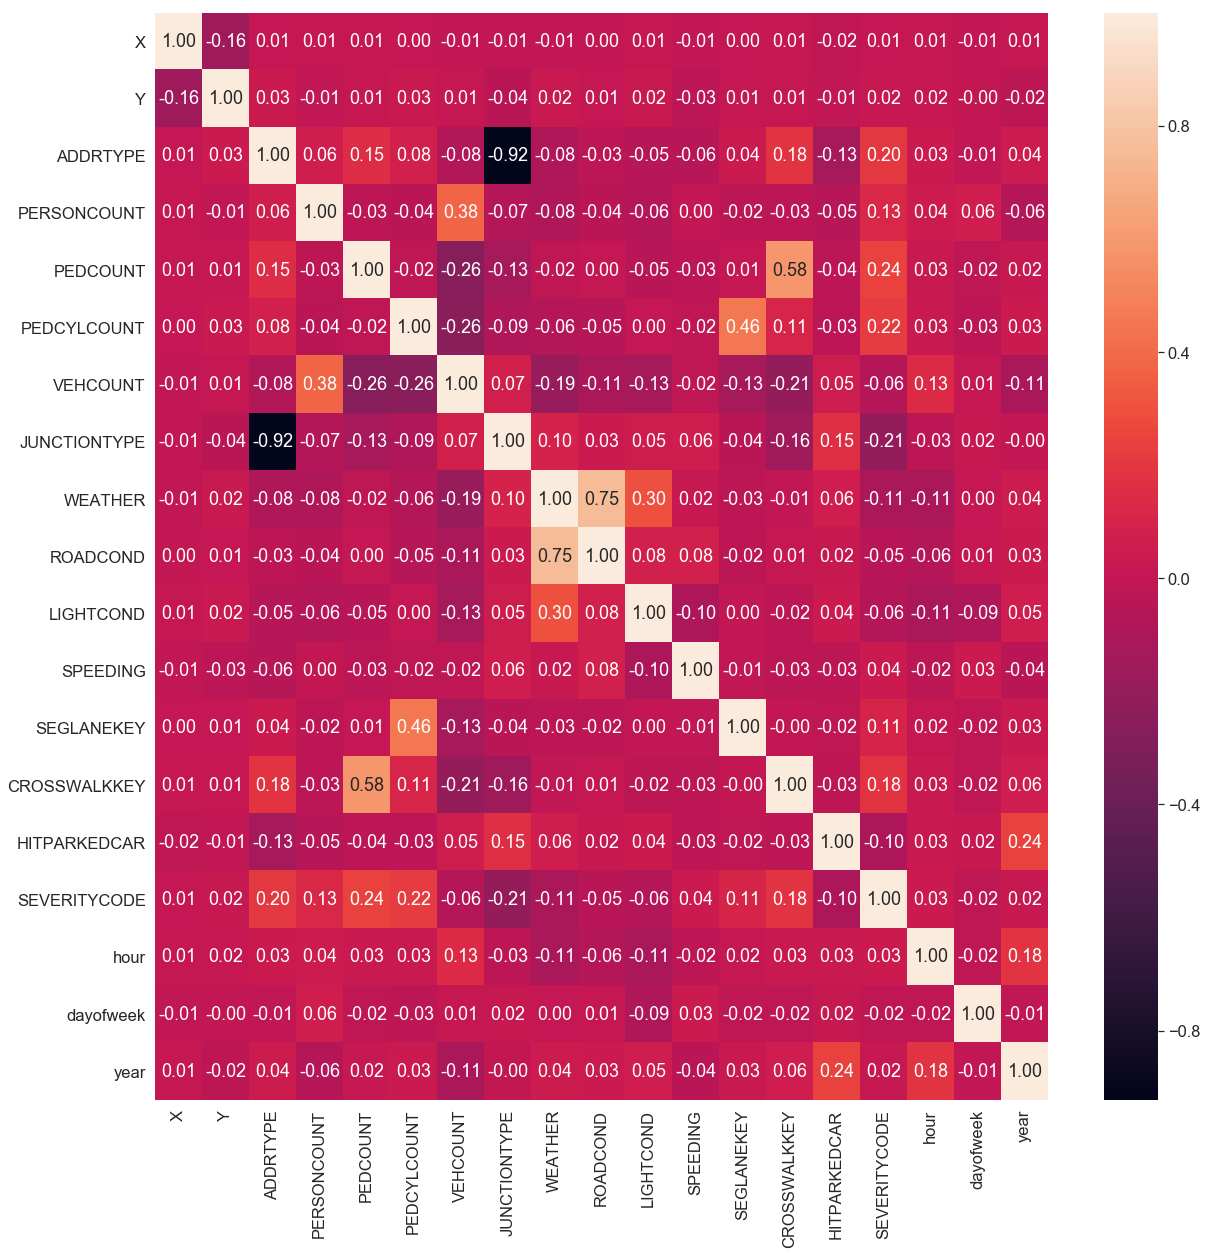

In [56]:
corr = train.corr()
plt.figure(figsize=(20, 20))
sns.heatmap(corr, annot=True, fmt=".2f")
sns.set(font_scale=0.5)
plt.savefig('correlation.jpg', dpi=600, bbox_inches='tight')
plt.show()

In [57]:
removed_columns=[]
correlation_threshold = 0.9
from scipy.stats import pearsonr
for c in train.columns:
    # correlation with pval
    for cc in train.columns:
        corrtest = pearsonr(train[c], train[cc])
        corr = corrtest[0]
        pval = corrtest[1]
        if cc != c and abs(corr) > correlation_threshold and pval < 0.05:
            print(c,' ', cc, ' correlation value ', float(corr))
            removed_columns.append([c,cc])

ADDRTYPE   JUNCTIONTYPE  correlation value  -0.922374850297305
JUNCTIONTYPE   ADDRTYPE  correlation value  -0.922374850297305


Drop one of the two higly correlated features

In [58]:
train = train.drop(['JUNCTIONTYPE'], axis=1)
test = test.drop(['JUNCTIONTYPE'], axis=1)

# Compute target record unbalance

In [59]:
len_total = len(train)
sel_1=train[train['SEVERITYCODE']==1]
len_1 = len(sel_1)
print("percentage severity code 1 in train set ", len_1/len_total*100.0)

len_total = len(test)
sel_1=test[test['SEVERITYCODE']==1]
len_1 = len(sel_1)
print("percentage severity code 1 in test set ", len_1/len_total*100.0)

percentage severity code 1 in train set  69.7514433974931
percentage severity code 1 in test set  69.74169147823288


# Save cleaned up dataframe

In [60]:
train.to_csv('Data-Collisions-train.csv')
test.to_csv('Data-Collisions-test.csv')

# Load cleaned dataframe

In [61]:
import numpy as np
import pandas as pd
pd.set_option('display.float_format', lambda x: '{:.3f}'.format(x)) #Limiting floats output to 3 decimal points
from matplotlib import pyplot as plt
%matplotlib inline
import seaborn as sns

In [62]:
train = pd.read_csv('Data-Collisions-train.csv')
train = train.drop(['Unnamed: 0'], axis=1)
train.dropna(inplace=True)
details = compute_details(train)
print(details)

                types  counts  distincts  nulls  missing ration
X             float64  126611      20683      0           0.000
Y             float64  126611      20923      0           0.000
ADDRTYPE        int64  126611          2      0           0.000
PERSONCOUNT     int64  126611         43      0           0.000
PEDCOUNT        int64  126611          6      0           0.000
PEDCYLCOUNT     int64  126611          3      0           0.000
VEHCOUNT        int64  126611         12      0           0.000
WEATHER         int64  126611         11      0           0.000
ROADCOND        int64  126611          9      0           0.000
LIGHTCOND       int64  126611          9      0           0.000
SPEEDING        int64  126611          2      0           0.000
SEGLANEKEY      int64  126611       1426      0           0.000
CROSSWALKKEY    int64  126611       1701      0           0.000
HITPARKEDCAR    int64  126611          2      0           0.000
SEVERITYCODE    int64  126611          2

In [63]:
test = pd.read_csv('Data-Collisions-test.csv')
test = test.drop(['Unnamed: 0'], axis=1)
test.dropna(inplace=True)
details = compute_details(test)
print(details)

                types  counts  distincts  nulls  missing ration
X             float64   62135      16045      0           0.000
Y             float64   62135      16194      0           0.000
ADDRTYPE        int64   62135          2      0           0.000
PERSONCOUNT     int64   62135         33      0           0.000
PEDCOUNT        int64   62135          5      0           0.000
PEDCYLCOUNT     int64   62135          3      0           0.000
VEHCOUNT        int64   62135         13      0           0.000
WEATHER         int64   62135         10      0           0.000
ROADCOND        int64   62135          9      0           0.000
LIGHTCOND       int64   62135          9      0           0.000
SPEEDING        int64   62135          2      0           0.000
SEGLANEKEY      int64   62135        739      0           0.000
CROSSWALKKEY    int64   62135        956      0           0.000
HITPARKEDCAR    int64   62135          2      0           0.000
SEVERITYCODE    int64   62135          2

# Separate label, compute weights array for XGBoost, and scale

In [64]:
y_train = train['SEVERITYCODE']
X_train= train.drop(['SEVERITYCODE'], axis=1)

y_test= test['SEVERITYCODE']
X_test= test.drop(['SEVERITYCODE'], axis=1)

In [65]:
from sklearn.utils import class_weight
def ComputeWeights(y_val):
    sample_weights = class_weight.compute_class_weight('balanced', np.unique(y_val), y_val)
    weights = []
    y_train = np.array(y_val)
    for i in range(len(y_val)):
        if y_val[i] == 1:
            weights.append(sample_weights[0])
        elif y_val[i] == 2:
            weights.append(sample_weights[1])

    weights = np.array(weights)
    
    return weights

In [66]:
from sklearn.preprocessing import StandardScaler

train_scaler = StandardScaler()
X_train_scaled = train_scaler.fit_transform(X_train)
X_test_scaled = train_scaler.transform(X_test)

X_train_scaled = np.array(X_train_scaled)
y_train = np.array(y_train)
weights = np.array(ComputeWeights(y_train))

X_test_scaled = np.array(X_test_scaled)
y_test = np.array(y_test)

d:\apps\python_3_7_4\lib\site-packages\sklearn\utils\validation.py:71: FutureWarning: Pass classes=[1 2], y=[1 1 1 ... 2 1 1] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)


# Functions for hyperparameter optimization

In [67]:
from sklearn.model_selection import GridSearchCV,cross_val_score
from sklearn.metrics import f1_score, classification_report,confusion_matrix,f1_score,log_loss
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb
import optuna

In [68]:
import itertools
def objectiveDecisionTree(trial):
    entropy_int = trial.suggest_int('entropy_int', 0, 1)
    max_depth = trial.suggest_int('max_depth', 1, 32)
    
    if entropy_int==0:
        criterion="gini"
    else:
        criterion="entropy"
    
    clf = DecisionTreeClassifier(criterion=criterion,max_depth=max_depth, class_weight='balanced',random_state=42)
    
    return cross_val_score(clf, X_train_scaled,y_train, n_jobs = 3, cv=3, scoring='neg_log_loss').mean()

def objectiveXGBoost(trial):
    gamma_int = trial.suggest_float('gamma', 0.05, 2,log=True)
    max_depth = trial.suggest_int('max_depth', 1, 32)
    
    fit_params={'sample_weight':weights}
    clf = xgb.XGBClassifier(n_jobs=3,seed=42,gamma=gamma_int,max_depth=max_depth)
    
    return cross_val_score(clf, X_train_scaled,y_train, fit_params = fit_params, n_jobs = 3, cv=3, scoring='neg_log_loss').mean()

def objectiveRandomForest(trial):
    entropy_int = trial.suggest_int('entropy_int', 0, 1)
    max_depth = trial.suggest_int('max_depth', 1, 32)
    
    if entropy_int==0:
        criterion="gini"
    else:
        criterion="entropy"
    
    clf = RandomForestClassifier(criterion=criterion,max_depth=max_depth, class_weight='balanced',random_state=42)
    
    return cross_val_score(clf, X_train_scaled,y_train, n_jobs = 3, cv=3, scoring='neg_log_loss').mean()
    
def PlotConfusionMatrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

# Decision tree model

In [69]:
study = optuna.create_study(direction='maximize')
study.optimize(objectiveDecisionTree, n_trials=50)
trial = study.best_trial
print(trial.params)

[I 2020-09-13 10:46:21,165] Trial 0 finished with value: -6.788661742170244 and parameters: {'entropy_int': 0, 'max_depth': 23}. Best is trial 0 with value: -6.788661742170244.
[I 2020-09-13 10:46:23,921] Trial 1 finished with value: -3.9372785884601647 and parameters: {'entropy_int': 0, 'max_depth': 19}. Best is trial 1 with value: -3.9372785884601647.
[I 2020-09-13 10:46:26,350] Trial 2 finished with value: -0.9216571704891732 and parameters: {'entropy_int': 0, 'max_depth': 12}. Best is trial 2 with value: -0.9216571704891732.
[I 2020-09-13 10:46:28,933] Trial 3 finished with value: -0.9272053790471472 and parameters: {'entropy_int': 1, 'max_depth': 12}. Best is trial 2 with value: -0.9216571704891732.
[I 2020-09-13 10:46:31,481] Trial 4 finished with value: -1.7285627656157523 and parameters: {'entropy_int': 0, 'max_depth': 15}. Best is trial 2 with value: -0.9216571704891732.
[I 2020-09-13 10:46:34,297] Trial 5 finished with value: -8.61413314585793 and parameters: {'entropy_int': 

[I 2020-09-13 10:48:10,119] Trial 45 finished with value: -0.5997643760928938 and parameters: {'entropy_int': 1, 'max_depth': 5}. Best is trial 17 with value: -0.5997643760928938.
[I 2020-09-13 10:48:12,547] Trial 46 finished with value: -0.6257344274831013 and parameters: {'entropy_int': 1, 'max_depth': 8}. Best is trial 17 with value: -0.5997643760928938.
[I 2020-09-13 10:48:15,199] Trial 47 finished with value: -0.7984540954535865 and parameters: {'entropy_int': 1, 'max_depth': 11}. Best is trial 17 with value: -0.5997643760928938.
[I 2020-09-13 10:48:17,148] Trial 48 finished with value: -0.6106605288948558 and parameters: {'entropy_int': 1, 'max_depth': 3}. Best is trial 17 with value: -0.5997643760928938.
[I 2020-09-13 10:48:18,989] Trial 49 finished with value: -0.6596527119760814 and parameters: {'entropy_int': 1, 'max_depth': 1}. Best is trial 17 with value: -0.5997643760928938.


{'entropy_int': 1, 'max_depth': 5}


In [70]:
tree_clf = DecisionTreeClassifier(criterion="gini",max_depth=6, class_weight='balanced',random_state=42)
tree_clf.fit(X_train_scaled, y_train) 
yhat = tree_clf.predict(X_test_scaled)

fscore = f1_score(y_test, yhat, average='weighted') 
print("f1score ",fscore)
from sklearn.metrics import accuracy_score
current_accuracy =  accuracy_score(y_test, yhat)
print("accuracy ", current_accuracy)

f1score  0.6355558162670842
accuracy  0.6209865615192726


Confusion matrix, without normalization
[[24222 19112]
 [ 4438 14363]]


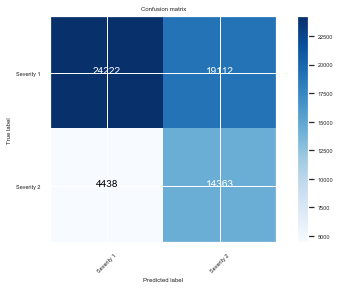

In [71]:
cnf_matrix = confusion_matrix(y_test, yhat, labels=[1,2])
PlotConfusionMatrix(cnf_matrix, classes=['Severity 1','Severity 2'],normalize= False,  title='Confusion matrix')

Feature importance

In [72]:
importances = tree_clf.feature_importances_
feature_labels = train.columns.values
indices = np.argsort(importances)
print(train.columns.values)

['X' 'Y' 'ADDRTYPE' 'PERSONCOUNT' 'PEDCOUNT' 'PEDCYLCOUNT' 'VEHCOUNT'
 'WEATHER' 'ROADCOND' 'LIGHTCOND' 'SPEEDING' 'SEGLANEKEY' 'CROSSWALKKEY'
 'HITPARKEDCAR' 'SEVERITYCODE' 'hour' 'dayofweek' 'year']


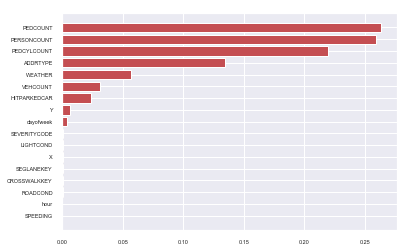

In [73]:
plt.barh(range(X_train_scaled.shape[1]), importances[indices], color="r", align="center")
plt.yticks(range(X_train_scaled.shape[1]), feature_labels[indices])
plt.savefig('feature_importance.jpg', dpi=600, bbox_inches='tight')
plt.show()


# XGBoost

In [74]:
study = optuna.create_study(direction='maximize')
study.optimize(objectiveXGBoost, n_trials=50)
trial = study.best_trial
print(trial.params)

[I 2020-09-13 10:48:46,957] Trial 0 finished with value: -0.5715285651907297 and parameters: {'gamma': 1.6146197029391238, 'max_depth': 13}. Best is trial 0 with value: -0.5715285651907297.
[I 2020-09-13 10:49:24,641] Trial 1 finished with value: -0.5940866291932067 and parameters: {'gamma': 0.8186758416550405, 'max_depth': 18}. Best is trial 0 with value: -0.5715285651907297.
[I 2020-09-13 10:50:10,451] Trial 2 finished with value: -0.6460598976635267 and parameters: {'gamma': 0.1804383891226164, 'max_depth': 22}. Best is trial 0 with value: -0.5715285651907297.
[I 2020-09-13 10:50:32,305] Trial 3 finished with value: -0.5695355063761018 and parameters: {'gamma': 0.346174315578003, 'max_depth': 10}. Best is trial 3 with value: -0.5695355063761018.
[I 2020-09-13 10:50:58,749] Trial 4 finished with value: -0.5689691002967792 and parameters: {'gamma': 1.9624667435399517, 'max_depth': 13}. Best is trial 4 with value: -0.5689691002967792.
[I 2020-09-13 10:51:13,853] Trial 5 finished with v

[I 2020-09-13 11:04:44,002] Trial 42 finished with value: -0.5670827027566565 and parameters: {'gamma': 0.35972771287385474, 'max_depth': 6}. Best is trial 40 with value: -0.5661675127133736.
[I 2020-09-13 11:04:57,417] Trial 43 finished with value: -0.5678117465031862 and parameters: {'gamma': 0.95735103725371, 'max_depth': 5}. Best is trial 40 with value: -0.5661675127133736.
[I 2020-09-13 11:05:06,237] Trial 44 finished with value: -0.5739442870940309 and parameters: {'gamma': 0.27238202422822094, 'max_depth': 2}. Best is trial 40 with value: -0.5661675127133736.
[I 2020-09-13 11:05:21,805] Trial 45 finished with value: -0.5670364583415772 and parameters: {'gamma': 0.3903921485259401, 'max_depth': 7}. Best is trial 40 with value: -0.5661675127133736.
[I 2020-09-13 11:05:41,838] Trial 46 finished with value: -0.569624819661383 and parameters: {'gamma': 0.5392401941480386, 'max_depth': 10}. Best is trial 40 with value: -0.5661675127133736.
[I 2020-09-13 11:05:54,366] Trial 47 finished

{'gamma': 0.5726981735568107, 'max_depth': 7}


In [82]:
xgboost_clf = xgb.XGBClassifier(n_jobs=3,seed=42, gamma = 0.5726981735568107,max_depth=7)
xgboost_clf.fit(X_train_scaled, y_train,sample_weight=weights) 
yhat = xgboost_clf.predict(X_test_scaled)

fscore = f1_score(y_test, yhat, average='weighted') 
print("f1score ",fscore)
from sklearn.metrics import accuracy_score
current_accuracy =  accuracy_score(y_test, yhat)
print("accuracy ", current_accuracy)

f1score  0.6956304888378425
accuracy  0.6853142351331778


Confusion matrix, without normalization
[[30370 12964]
 [ 6589 12212]]


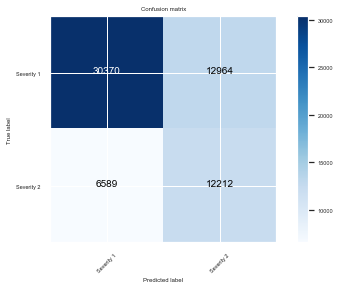

In [83]:
cnf_matrix = confusion_matrix(y_test, yhat, labels=[1,2])
PlotConfusionMatrix(cnf_matrix, classes=['Severity 1','Severity 2'],normalize= False,  title='Confusion matrix')

# Random forest

In [77]:
study = optuna.create_study(direction='maximize')
study.optimize(objectiveRandomForest, n_trials=50)
trial = study.best_trial
print(trial.params)

[I 2020-09-13 11:07:00,875] Trial 0 finished with value: -0.5626527166603429 and parameters: {'entropy_int': 0, 'max_depth': 14}. Best is trial 0 with value: -0.5626527166603429.
[I 2020-09-13 11:07:20,638] Trial 1 finished with value: -0.560353628227596 and parameters: {'entropy_int': 1, 'max_depth': 15}. Best is trial 1 with value: -0.560353628227596.
[I 2020-09-13 11:07:29,022] Trial 2 finished with value: -0.6022340418378126 and parameters: {'entropy_int': 1, 'max_depth': 4}. Best is trial 1 with value: -0.560353628227596.
[I 2020-09-13 11:07:45,673] Trial 3 finished with value: -0.5487022003197993 and parameters: {'entropy_int': 0, 'max_depth': 18}. Best is trial 3 with value: -0.5487022003197993.
[I 2020-09-13 11:08:10,141] Trial 4 finished with value: -0.5348475533755873 and parameters: {'entropy_int': 1, 'max_depth': 29}. Best is trial 4 with value: -0.5348475533755873.
[I 2020-09-13 11:08:30,387] Trial 5 finished with value: -0.5344130269690016 and parameters: {'entropy_int': 

[I 2020-09-13 11:21:59,703] Trial 45 finished with value: -0.5363609825863928 and parameters: {'entropy_int': 0, 'max_depth': 22}. Best is trial 21 with value: -0.5321801291908165.
[I 2020-09-13 11:22:22,657] Trial 46 finished with value: -0.5321801291908165 and parameters: {'entropy_int': 0, 'max_depth': 25}. Best is trial 21 with value: -0.5321801291908165.
[I 2020-09-13 11:22:45,335] Trial 47 finished with value: -0.5330346293854712 and parameters: {'entropy_int': 0, 'max_depth': 23}. Best is trial 21 with value: -0.5321801291908165.
[I 2020-09-13 11:23:01,552] Trial 48 finished with value: -0.5626527166603429 and parameters: {'entropy_int': 0, 'max_depth': 14}. Best is trial 21 with value: -0.5321801291908165.
[I 2020-09-13 11:23:24,272] Trial 49 finished with value: -0.5369562254802909 and parameters: {'entropy_int': 0, 'max_depth': 30}. Best is trial 21 with value: -0.5321801291908165.


{'entropy_int': 0, 'max_depth': 25}


In [84]:
random_forest_clf = RandomForestClassifier(criterion="gini",max_depth=25, class_weight='balanced',random_state=42)
random_forest_clf.fit(X_train_scaled, y_train) 
yhat = random_forest_clf.predict(X_test_scaled)

fscore = f1_score(y_test, yhat, average='weighted') 
print("f1score ",fscore)
from sklearn.metrics import accuracy_score
current_accuracy =  accuracy_score(y_test, yhat)
print("accuracy ", current_accuracy)

f1score  0.7193852180329486
accuracy  0.7336605777742014


Confusion matrix, without normalization
[[37724  5610]
 [10939  7862]]


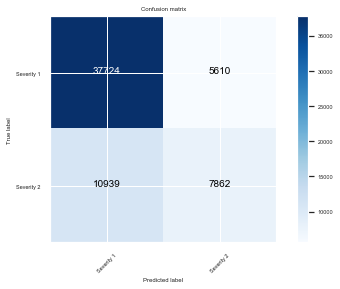

In [85]:
cnf_matrix = confusion_matrix(y_test, yhat, labels=[1,2])
PlotConfusionMatrix(cnf_matrix, classes=['Severity 1','Severity 2'],normalize= False,  title='Confusion matrix')

# Voting classifier

In [86]:
from mlxtend.classifier import EnsembleVoteClassifier
models =[tree_clf,xgboost_clf,random_forest_clf]

voting_clf = EnsembleVoteClassifier(clfs=models, voting='soft',refit=False)
voting_clf.fit(X_train_scaled, y_train)
yhat = voting_clf.predict(X_test_scaled)

fscore = f1_score(y_test, yhat, average='weighted') 
print("f1score ",fscore)
from sklearn.metrics import accuracy_score
current_accuracy =  accuracy_score(y_test, yhat)
print("accuracy ", current_accuracy)

f1score  0.7150552148963427
accuracy  0.7119015047879617


Confusion matrix, without normalization
[[33588  9746]
 [ 8155 10646]]


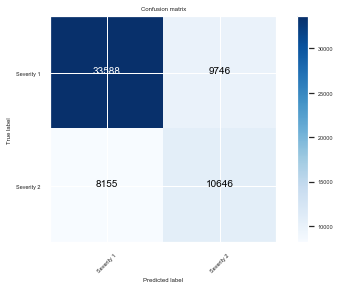

In [87]:
cnf_matrix = confusion_matrix(y_test, yhat, labels=[1,2])
PlotConfusionMatrix(cnf_matrix, classes=['Severity 1','Severity 2'],normalize= False,  title='Confusion matrix')